# Near-Native Experiments (Fig 2)

We use Benchmark 1 (derived from past RNA Puzzle challenges) to assess near-native selection.

Pdbs are available at https://purl.stanford.edu/bn398fc4306 under `augmented_puzzles`.

All scorer predictions and translations are at `benchmark1.csv`.

In [1]:
import collections as col
import math
import re

import matplotlib
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as ss

In [2]:
def get_puzzle_number(x):
    num = re.search('_(\d+)(_|$)', x).group(1)
    if num == "14":
        if "bound" in x:
            num = "14b"
        else:
            num = "14f"
    return num

In [3]:
benchmark1 = pd.read_csv('new_benchmark1.csv', dtype={'puzzle_number': object}) #puzzle_number一列在单列中包括多个dtype，那么使用object来容纳所有的dtype

## Top N near-native performance (Fig 2A + 2B)

We measure different scoring method's ability to correctly pick out the generated structures that are close to the experimental structure (< 2Å RMSD).  We phrase this as a top N problem where we look at the best quality structure within a fixed number of each method's most highly ranked candidates.

In [4]:
# Extract best N RMSDs
bestN_rmsds = col.defaultdict(list)

for puzzle_number, group in benchmark1.groupby('puzzle_number'):
    bestN_rmsds['puzzle_number'].append(puzzle_number)
    for score_name in ['ares', 'rosetta', '3drnascore', 'rasp']:
        tmp = group[['source', score_name, 'rms']]
        tmp = tmp[tmp['source'].apply(lambda x: x in ['near_natives', 'decoys'])]
        tmp = tmp.sort_values(score_name).reset_index()
        best10_rmsd = tmp.iloc[:10].rms.min()
        best1_rmsd = tmp.iloc[:1].rms.min()
        bestN_rmsds['best_10_rmsd_{:}'.format(score_name)].append(best10_rmsd)
        bestN_rmsds['best_1_rmsd_{:}'.format(score_name)].append(best1_rmsd)
bestN_rmsds = pd.DataFrame(bestN_rmsds)

In [5]:
def plot_bestN_rmsd(score_name1, score_name2, N):                                                                                                                                                                                                                                                                                                                              
    min_val = 0             
    if N == 1:
        max_val = 31
    else:
        max_val = 21
    fig, ax = plt.subplots()                                                       
                                                                                   
    fig.patch.set_alpha(0)                                                         
    ax.scatter(bestN_rmsds['best_{:}_rmsd_{:}'.format(N, score_name1)], bestN_rmsds['best_{:}_rmsd_{:}'.format(N, score_name2)], s=50, marker='+',
     zorder=10, color='red', lw=1)                                                 
    line = mlines.Line2D([0, 1], [0, 1], color='blue', lw=0.5)                     
    transform = ax.transAxes                                                       
    line.set_transform(transform)                                                  
    ax.add_line(line)                                                              
    plt.ylabel('{:} best RMSD'.format(score_name2))                                                  
    plt.xlabel('{:} best RMSD'.format(score_name1))                                
    ax.set_xlim(min_val, max_val)                                                  
    ax.set_ylim(min_val, max_val)                                                  
    ax.set_aspect('equal', 'box')                                                  
    plt.xticks(np.arange(0, max_val, 5))                                           
    plt.yticks(np.arange(0, max_val, 5))                                           
    plt.grid(True, lw=0.25)                                                        
    #plt.title('Best RMSD in Top {:} Structure {:}'.format(N, score_name))        
    plt.show() 

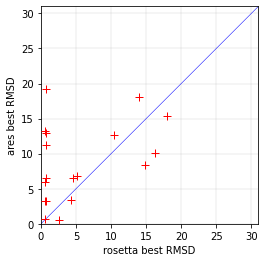

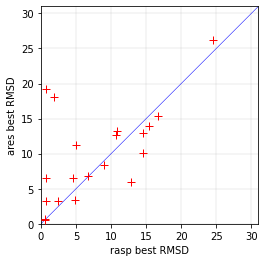

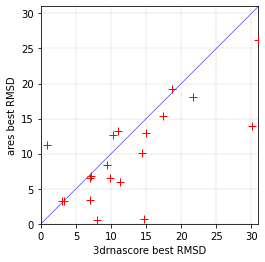

In [6]:
plot_bestN_rmsd('rosetta', 'ares', 1)
plot_bestN_rmsd('rasp', 'ares', 1)
plot_bestN_rmsd('3drnascore', 'ares', 1)

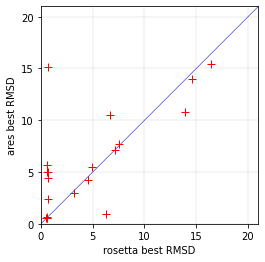

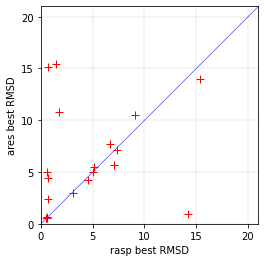

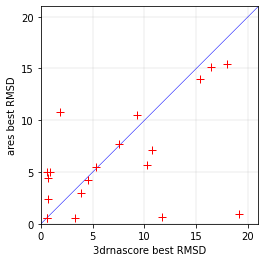

In [7]:
plot_bestN_rmsd('rosetta', 'ares', 10)
plot_bestN_rmsd('rasp', 'ares', 10)
plot_bestN_rmsd('3drnascore', 'ares', 10)

## Near-native selection (Fig 2C)

We measure different scoring method's ability to rank generated structures that are close to the experimental structure (< 2Å RMSD).

In [8]:
# Extract near native ranks
nearnative_ranks = col.defaultdict(list)

for puzzle_number, group in benchmark1.groupby('puzzle_number'):
    nearnative_ranks['puzzle_number'].append(puzzle_number)
    for score_name in ['ares', 'rosetta', '3drnascore', 'rasp']:
        tmp = group[['source', score_name, 'rms']]
        tmp = tmp[tmp['source'].apply(lambda x: x in ['near_natives', 'decoys'])]
        tmp = tmp.sort_values(score_name).reset_index()
        near_native_rank = tmp[tmp['rms'] < 2].index[0]
        nearnative_ranks['rmsd_2_rank_{:}'.format(score_name)].append(near_native_rank)
nearnative_ranks = pd.DataFrame(nearnative_ranks)

In [9]:
# Plot as log-log scatter.

def plot_nearnative_rank(score_name1, score_name2):
    min_val = 0.5
    max_val = 100000
    fig, ax = plt.subplots()
    fig.patch.set_alpha(0)
    ax.scatter(nearnative_ranks['rmsd_2_rank_{:}'.format(score_name1)] + 1, nearnative_ranks['rmsd_2_rank_{:}'.format(score_name2)] + 1, s=50, marker='+', zorder=10, color='red', lw=1)
    plt.yscale('log')
    plt.xscale('log')
    line = mlines.Line2D([0, 1], [0, 1], color='blue', lw=0.5)
    transform = ax.transAxes
    line.set_transform(transform)
    ax.add_line(line)
    plt.ylabel('{:} rank'.format(score_name2))
    plt.xlabel('{:} rank'.format(score_name1))
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    ax.patch.set_alpha(1)
    ax.set_aspect('equal', 'box')
    plt.grid(True, lw=0.25)
    plt.title('Rank of First < 2 RMSD Structure')
    ax.set_xticklabels(['', '', '$1$', '$10$', '$10^2$', '$10^3$', '$10^4$', '$10^5$'])
    ax.set_yticklabels(['', '', '$1$', '$10$', '$10^2$', '$10^3$', '$10^4$', '$10^5$'])
    plt.show()

C:\Users\hyc\AppData\Local\Temp/ipykernel_11020/4233954040.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', '', '$1$', '$10$', '$10^2$', '$10^3$', '$10^4$', '$10^5$'])
C:\Users\hyc\AppData\Local\Temp/ipykernel_11020/4233954040.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['', '', '$1$', '$10$', '$10^2$', '$10^3$', '$10^4$', '$10^5$'])


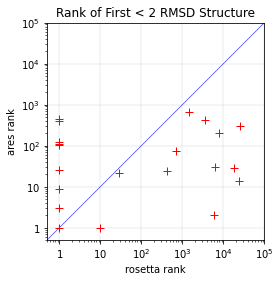

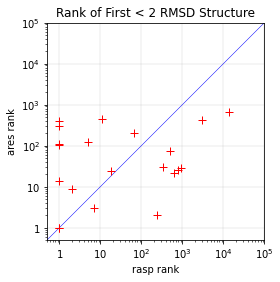

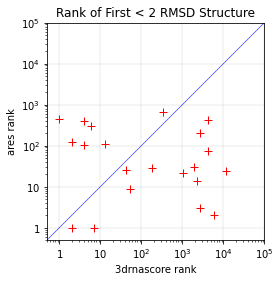

In [10]:
plot_nearnative_rank('rosetta', 'ares')
plot_nearnative_rank('rasp', 'ares')
plot_nearnative_rank('3drnascore', 'ares')

## Top N near-native performance, quantized (Fig S3)

We measure different scoring method's ability to correctly pick out the generated structures that are close to the experimental structure (< 2Å RMSD).  We phrase this as a top N problem where we look at the best quality structure within a fixed number of each method's most highly ranked candidates.  In this case we quantize the results by results <2 Å, <5 Å, and < 10 Å RMSD.

In [11]:
# We quantize best rmsd found within different sized subsets, for different RMSD thresholds, for different scoring methods.
count_thresholds = [1, 10, 100, 1000, 10000, 100000]
rmsd_thresholds = [10000, 10, 5, 2]

best_rmsds = col.defaultdict(list)
for name, group in benchmark1.groupby('puzzle_number'):
    for n in count_thresholds:
        best_rmsds['puzzle_number'].append(name)
        best_rmsds['n'].append(n)
        for score_name in ['ares', 'rosetta', '3drnascore', 'rasp']:
            tmp = group[['source', score_name, 'rms']].dropna()
            tmp = tmp[tmp['source'].apply(lambda x: x in ['near_natives', 'decoys'])]
            tmp = tmp.sort_values(score_name).reset_index()
            
            best_rmsd_top_n = np.min(tmp['rms'].iloc[:n])

            # We assign a category based on RMSD threshold.
            tmp = None
            for i, thresh in enumerate(rmsd_thresholds):
                if best_rmsd_top_n < thresh:
                    tmp = i
            best_rmsd_top_n = tmp
            best_rmsds['best_rmsd_top_n_{:}'.format(score_name)].append(best_rmsd_top_n)
            
best_rmsds = pd.DataFrame(best_rmsds)

In [12]:
# Pretty printing and ordering of RNA puzzles

canonical_order = list(range(1, 22))
canonical_order.insert(14, 14)
canonical_order = [str(x) for x in canonical_order]
canonical_order[13] = canonical_order[13] + 'b' 
canonical_order[14] = canonical_order[14] + 'f'

def ready_for_print(rna_num):
    tmp = int(re.sub('[^0-9]','', rna_num))
    if tmp < 10:
        return ' ' + rna_num
    return rna_num

In [13]:
# Reformat in preparation for display.
thresholds = [1, 10, 100]

names = best_rmsds['puzzle_number'].unique()
pcolor = []
for score_name in ['ares', 'rosetta', '3drnascore', 'rasp']:
    pcolor_results = []
    for n in thresholds:
        curr_results = []
        for name in names:
            curr = best_rmsds[(best_rmsds['puzzle_number'] == name) & (best_rmsds['n'] == n)]
            assert len(curr) == 1
            curr_results.append(curr['best_rmsd_top_n_{:}'.format(score_name)].iloc[0])
        pcolor_results.append(curr_results)
    pcolor_results = pd.DataFrame(np.array(pcolor_results).T, columns=['{:}_{:}'.format(x, score_name) for x in thresholds])
    pcolor.append(pcolor_results)
pcolor = pd.concat(pcolor + [pd.Series(names, name='puzzle_number'),], axis=1)
pcolor.puzzle_number = pcolor.puzzle_number.astype("category")
pcolor.puzzle_number.cat.set_categories(canonical_order, inplace=True)
pcolor = pcolor.sort_values('puzzle_number', ascending=False)

C:\ProgramData\Anaconda3\envs\tensorflow2\lib\site-packages\pandas\core\arrays\categorical.py:2747: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


C:\Users\hyc\AppData\Local\Temp/ipykernel_11020/1049396054.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set_yticklabels(pcolor['puzzle_number'].apply(ready_for_print), fontdict={'horizontalalignment': 'left'})
C:\Users\hyc\AppData\Local\Temp/ipykernel_11020/1049396054.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set_xticklabels(thresholds)
C:\Users\hyc\AppData\Local\Temp/ipykernel_11020/1049396054.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(thresholds)
C:\Users\hyc\AppData\Local\Temp/ipykernel_11020/1049396054.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(thresholds)
C:\Users\hyc\AppData\Local\Temp/ipykernel_11020/1049396054.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(thresholds)


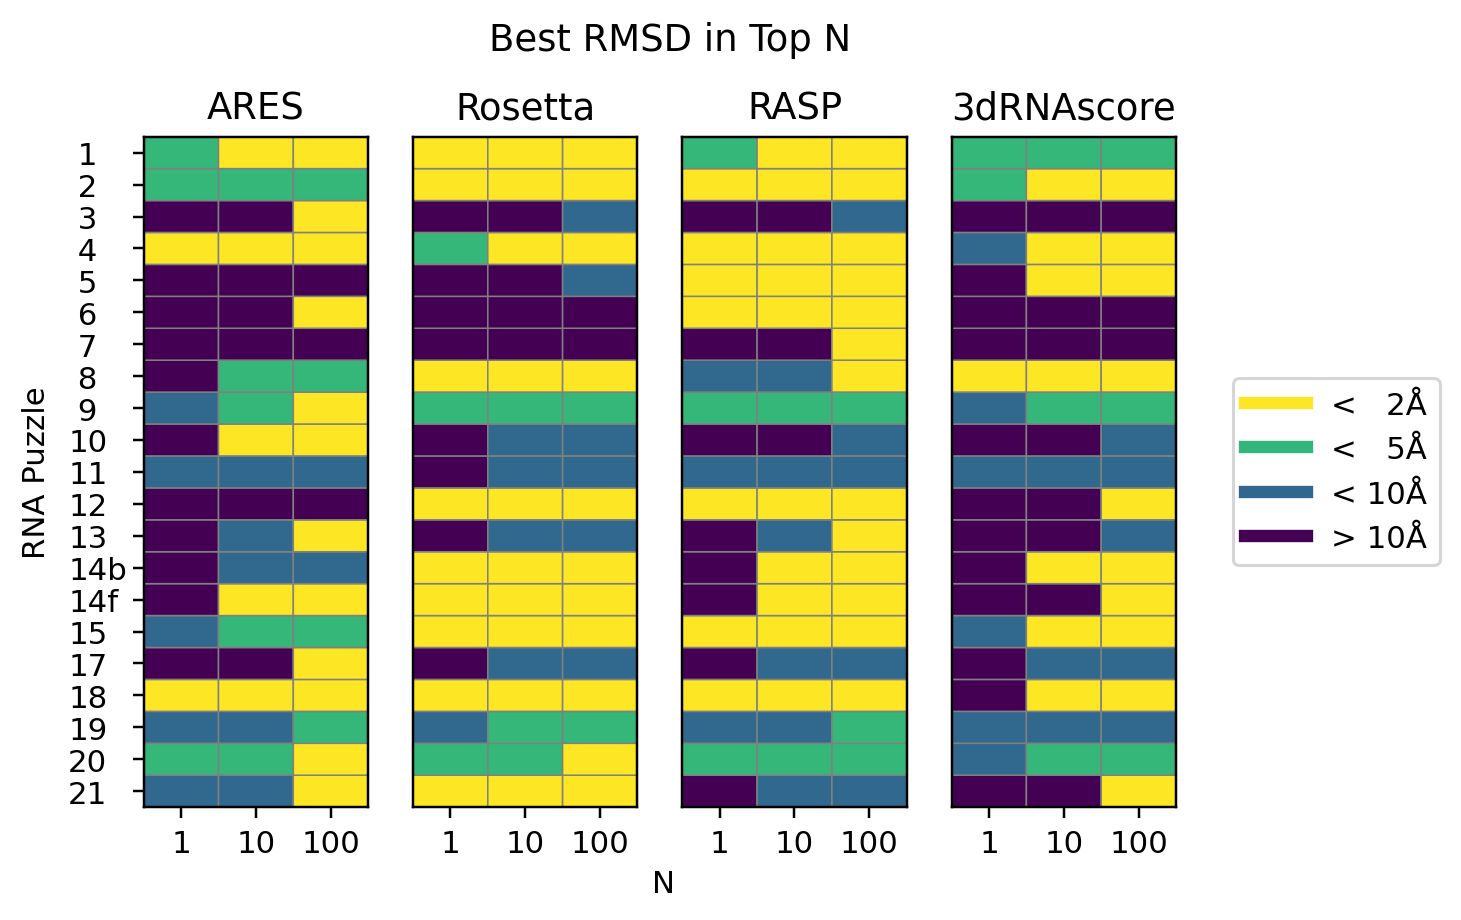

In [14]:
#matplotlib 3.4.2，使用更高版本的会报错
'''
TypeError                                 Traceback (most recent call last)
~\AppData\Local\Temp/ipykernel_23456/4076313389.py in <module>
     22 cmap = matplotlib.cm.get_cmap('viridis')
     23 ax0.pcolor(pcolor[['{:}_ares'.format(x) for x in thresholds]], edgecolors='gray', linewidths=0.5, cmap=cmap, vmin=0, vmax=3)
---> 24 ax0.set_yticklabels(pcolor['puzzle_number'].apply(ready_for_print), {'horizontalalignment': 'left'})
     25 ax0.tick_params(axis='y', pad=21)
     26 ax0.set_yticks(np.arange(pcolor.shape[0]) + 0.5, minor=False)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py in wrapper(self, *args, **kwargs)
     73 
     74         def wrapper(self, *args, **kwargs):
---> 75             return get_method(self)(*args, **kwargs)
     76 
     77         wrapper.__module__ = owner.__module__

TypeError: _set_ticklabels() takes 2 positional arguments but 3 were given

'''
#修改代码后更高版本也成功跑通，
# 即把ax0.set_yticklabels(pcolor['puzzle_number'].apply(ready_for_print), {'horizontalalignment': 'left'})改为：
# ax0.set_yticklabels(pcolor['puzzle_number'].apply(ready_for_print), fontdict={'horizontalalignment': 'left'})

# Plot as pcolor across puzzle, rmsd, count, and scorer dimensions.
fig = plt.figure(dpi=222)
ax = fig.add_subplot(111)    # Big subplot used to position display elements.
ax0 = fig.add_subplot(141)
ax1 = fig.add_subplot(142)
ax2 = fig.add_subplot(143)
ax3 = fig.add_subplot(144)

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')
ax.yaxis.set_ticks_position('none')
ax.set_yticklabels([])
ax.yaxis.set_ticks([])
ax.xaxis.set_ticks_position('none')
ax.set_xticklabels([])
ax.xaxis.set_ticks([])

cmap = matplotlib.cm.get_cmap('viridis')
ax0.pcolor(pcolor[['{:}_ares'.format(x) for x in thresholds]], edgecolors='gray', linewidths=0.5, cmap=cmap, vmin=0, vmax=3)
# ax0.set_yticklabels(pcolor['puzzle_number'].apply(ready_for_print), {'horizontalalignment': 'left'})
ax0.set_yticklabels(pcolor['puzzle_number'].apply(ready_for_print), fontdict={'horizontalalignment': 'left'})
ax0.tick_params(axis='y', pad=21)
ax0.set_yticks(np.arange(pcolor.shape[0]) + 0.5, minor=False)
ax0.set_xticklabels(thresholds)
ax0.set_xticks(np.arange(len(thresholds)) + 0.5, minor=False)
ax0.title.set_text('ARES')

ax1.pcolor(pcolor[['{:}_rosetta'.format(x) for x in thresholds]], edgecolors='gray', linewidths=0.5, cmap=cmap, vmin=0, vmax=3)
ax1.set_yticklabels([])
ax1.set_yticks([])
ax1.set_xticklabels(thresholds)
ax1.set_xticks(np.arange(len(thresholds)) + 0.5, minor=False)
ax1.title.set_text('Rosetta')

ax2.pcolor(pcolor[['{:}_rasp'.format(x) for x in thresholds]], edgecolors='gray', linewidths=0.5, cmap=cmap, vmin=0, vmax=3)
ax2.set_yticklabels([])
ax2.set_yticks([])
ax2.set_xticklabels(thresholds)
ax2.set_xticks(np.arange(len(thresholds)) + 0.5, minor=False)
ax2.title.set_text('RASP')

ax3.pcolor(pcolor[['{:}_3drnascore'.format(x) for x in thresholds]], edgecolors='gray', linewidths=0.5, cmap=cmap, vmin=0, vmax=3)
ax3.set_yticklabels([])
ax3.set_yticks([])
ax3.set_xticklabels(thresholds)
ax3.set_xticks(np.arange(len(thresholds)) + 0.5, minor=False)
ax3.title.set_text('3dRNAscore')

ax.set_xlabel('N', x=0.63, labelpad=20)
ax.set_ylabel('RNA Puzzle', labelpad=30)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

custom_lines = [mlines.Line2D([0], [0], color=cmap(1.), lw=4),
                mlines.Line2D([0], [0], color=cmap(.66), lw=4),
                mlines.Line2D([0], [0], color=cmap(.33), lw=4),
                mlines.Line2D([0], [0], color=cmap(0.), lw=4)]
ax.legend(custom_lines, 
          [ u'<   2Å', u'<   5Å', u'< 10Å', u'> 10Å'], 
          loc='center left', bbox_to_anchor=(1.3, 0.5))

plt.suptitle('Best RMSD in Top N', x=0.52, y=1.01)
plt.show()

## Detailed scatter plots (Fig S4)

Scatter plots looking at near-native and decoys scores vs. RMSDs.

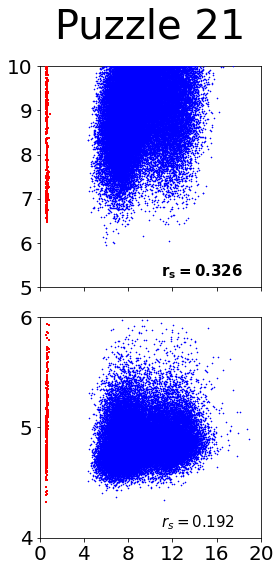

In [15]:
n = 10

puzzles = [
    ('1', 10),
    ('2', 10),
    ('3', 20),
    ('4', 10),
    ('5', 40),
    ('6', 40),
    ('7', 40),
    ('8', 10),
    ('9', 10),
    ('10', 40),
    ('11', 10),
    ('12', 40),
    ('13', 20),
    ('14b', 10),
    ('14f', 40),
    ('15', 10),
    ('17', 20),
    ('18', 10),
    ('19', 10),
    ('20', 10),
    ('21', 20),
]

for (puzzle_number, max_rmsd) in puzzles:
    plt.close()
    fig, axs = plt.subplots(2, 1, figsize=(4, 8) , sharex=True)
    fig.patch.set_alpha(0)
    
    
    axs[0].set_title('Puzzle {:}'.format(puzzle_number), y=1.1, fontsize=40)
    
    
    subset = benchmark1[benchmark1['puzzle_number'] == puzzle_number][['ares', 'rosetta', 'rms', 'source']].dropna()
    subset = subset[subset['source'].apply(lambda x: x in ['near_natives', 'decoys'])]
    
    # Offset and apply log to compress rosetta scores.
    subset['rosetta'] += 100
    subset['rosetta'] = np.log(subset['rosetta'])
    
    ax = axs[0]
    ax_rosetta = axs[1]
    ax.patch.set_alpha(1)
    ax_rosetta.patch.set_alpha(1)
    near_natives = subset[subset['source'] == 'near_natives']
    # Some near natives failed to converge, we just throw those out.
    near_natives = near_natives[near_natives['rms'] < 5]
    decoys = subset[subset['source'] == 'decoys']
    
    ax.scatter(near_natives['rms'], near_natives['ares'], s=5, marker='+', zorder=10, color='red', lw=2)
    ax.scatter(decoys['rms'], decoys['ares'], s=5, marker='+', zorder=10, color='blue', lw=0.5)
                
    ax_rosetta.scatter(near_natives['rms'], near_natives['rosetta'], s=5, marker='+', zorder=10, color='red', lw=2)
    ax_rosetta.scatter(decoys['rms'], decoys['rosetta'], s=5, marker='+', zorder=10, color='blue', lw=0.5)
    
    # Correlation plotting routines.
    float_corr = ss.spearmanr(decoys['ares'], decoys['rms']).correlation
    float_corr_rosetta = ss.spearmanr(decoys['rosetta'], decoys['rms']).correlation
    corr = '$r_s = {:6.3f}$'.format(float_corr)
    corr_rosetta = '$r_s = {:6.3f}$'.format(float_corr_rosetta)
    if float_corr > float_corr_rosetta:
        corr = corr[0] + '\mathbf{' + corr[1:-1] + '}' + corr[-1]
    else:
        corr_rosetta = corr_rosetta[0] + '\mathbf{' + corr_rosetta[1:-1] + '}' + corr_rosetta[-1]
        
    # Axis limit routines.
    buffery_rosetta = np.std(decoys['rosetta']) / 2
    buffery = np.std(decoys['ares']) / 2
    lim_rosetta = [math.floor(np.min(subset['rosetta'])), math.ceil(np.percentile(subset['rosetta'], 70) + buffery_rosetta)]
    ax_rosetta.set_ylim(lim_rosetta)
    yticks_rosetta = np.arange(math.ceil(lim_rosetta[0]), lim_rosetta[1] + 1e-3, 1)
    lim = [math.floor(np.min(subset['ares'])), math.ceil(np.percentile(subset['ares'], 70) +  buffery)]
    ax.set_ylim(lim)
    yticks = np.arange(math.ceil(lim[0]), lim[1] + 1e-3, 1)
    ax.set_xlim([0, max_rmsd])
    ax.xaxis.set_ticks(np.linspace(0, max_rmsd, 6))
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_xticklabels(np.linspace(0, max_rmsd, 6).astype(int))
    ax_rosetta.set_xlim([0, max_rmsd])
    ax.yaxis.set_ticks(yticks)
    ax_rosetta.yaxis.set_ticks(yticks_rosetta)
    
    fig.canvas.draw()
    ax_rosetta.tick_params(axis='both', which='major', labelsize=20)
    ax.text(0.55, 0.05, corr, transform=ax.transAxes,
        color='black', fontsize=15)
    ax_rosetta.text(0.55, 0.05, corr_rosetta, transform=ax_rosetta.transAxes,
        color='black', fontsize=15)
    
    plt.tight_layout()
    plt.savefig('Puzzle_{:}.png'.format(puzzle_number), dpi=266)
    
plt.show()